In [3]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from fab.utils.plotting import plot_contours, plot_marginal_pair
from experiments.make_flow import make_wrapped_normflow_realnvp
import models.ddpm
import models.mlp
import pdb
from typing import Callable
from tqdm import tqdm
from models.ddpm import GaussianDiffusion, TMLP
from models.mlp import MyMLP, SpectralNormMLP

import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *

import torch
import torchsde

from functorch import vmap

from torchdiffeq import odeint

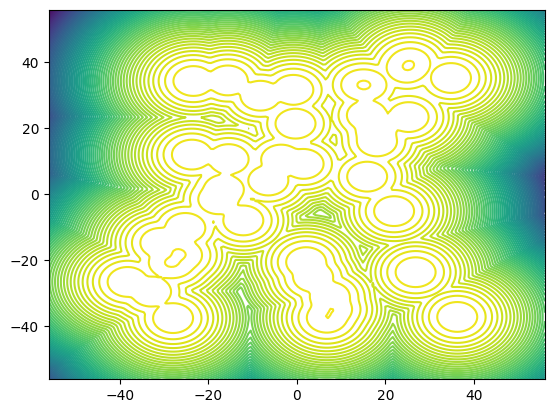

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dim = 2
n_mixes = 40
loc_scaling = 40.0  # scale of the problem (changes how far apart the modes of each Guassian component will be)
log_var_scaling = 1.0  # variance of each Gaussian
seed = 0

if device == "cpu":
    use_gpu = False
else:
    use_gpu = True

torch.manual_seed(0)  # seed of 0 for GMM problem
target = GMM(
    dim=dim,
    n_mixes=n_mixes,
    loc_scaling=loc_scaling,
    log_var_scaling=log_var_scaling,
    use_gpu=use_gpu,
    true_expectation_estimation_n_samples=int(1e5),
)
# plot target
target.to("cpu")
fig, ax = plt.subplots()
plotting_bounds = (-loc_scaling * 1.4, loc_scaling * 1.4)
plot_contours(
    target.log_prob,
    bounds=plotting_bounds,
    n_contour_levels=80,
    ax=ax,
    grid_width_n_points=200,
)
target.to(device)

## Helper functions

In [6]:
def plot_dataset(samples, gen_samples=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    target.to("cpu")
    plot_contours(
        target.log_prob,
        bounds=plotting_bounds,
        ax=axs[0],
        n_contour_levels=50,
        grid_width_n_points=200,
    )

    # plot dataset samples
    plot_marginal_pair(samples, ax=axs[0], bounds=plotting_bounds)
    axs[0].set_title("Buffer")

    if gen_samples is not None:
        plot_contours(
            target.log_prob,
            bounds=plotting_bounds,
            ax=axs[1],
            n_contour_levels=50,
            grid_width_n_points=200,
        )
        # plot generated samples
        plot_marginal_pair(gen_samples, ax=axs[1], bounds=plotting_bounds)
        axs[1].set_title("Generated samples")

    else:
        # delete subplot
        fig.delaxes(axs[1])

    target.to(device)
    plt.show()
    return [fig]

In [7]:
# calculate the log expectation of the reward
def log_E_R(_x, _t, noise_schedule, num_mc_samples):
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)

    h_t = noise_schedule.h(repeated_t).unsqueeze(1)
    samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t**0.5)

    log_rewards = target.log_prob(samples)
    return torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)


def clip_norm(max_norm: float, callee_method: Callable):
    def fxn(*args, **kwargs):
        output = callee_method(*args, **kwargs)

        norm = torch.linalg.vector_norm(est_scores_n, dim=-1)
        clip_coeff = torch.clamp(max_norm / (norm + 1e-6), max=1)

        return output * clip_coeff.unsqueeze(-1)

    return fxn


def estimate_grad_Rt(x, t, noise_schedule, num_mc_samples=200):
    if x.ndim == 1:
        x = x.unsqueeze(0)
        t = t.unsqueeze(0)

    grad_fxn = torch.vmap(
        torch.func.grad(log_E_R), in_dims=(0, 0, None, None), randomness="different"
    )

    return grad_fxn(x, t, noise_schedule, num_mc_samples)


def estimate_score_diffusion(x, t, noise_schedule, num_mc_samples=10):
    repeated_x = x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)

    h_t = noise_schedule.h(repeated_t).unsqueeze(-1)
    noised_x = repeated_x + torch.randn_like(repeated_x) * (h_t**0.5)

    conditional_scores = -(noised_x - repeated_x) / h_t
    return conditional_scores.mean(dim=0)

## Noise schedules

In [8]:
from abc import ABC, abstractmethod


class NoiseSchedule(ABC):
    @abstractmethod
    def g(t):
        # Returns g(t)
        pass

    @abstractmethod
    def h(t):
        # Returns \int_0^t g(t)^2 dt
        pass


class LinearNoiseSchedule(NoiseSchedule):
    def __init__(self, beta, norm_factor=1.0):
        self.beta = beta / norm_factor
        self.norm_factor = norm_factor

    def g(self, t):
        return self.beta.sqrt()

    def h(self, t):
        return self.beta * t


class GeometricNoiseSchedule(NoiseSchedule):
    def __init__(self, sigma_min, sigma_max, norm_factor=1.0):
        self.sigma_min = sigma_min / norm_factor
        self.sigma_max = sigma_max / norm_factor
        self.sigma_diff = self.sigma_max / self.sigma_min

        self.norm_factor = norm_factor

    def g(self, t):
        # Let sigma_d = sigma_max / sigma_min
        # Then g(t) = sigma_min * sigma_d^t * sqrt{2 * log(sigma_d)}
        # See Eq 192 in https://arxiv.org/pdf/2206.00364.pdf
        return (
            self.sigma_min
            * (self.sigma_diff**t)
            * ((2 * np.log(self.sigma_diff)) ** 0.5)
        )

    def h(self, t):
        # Let sigma_d = sigma_max / sigma_min
        # Then h(t) = \int_0^t g(z)^2 dz = sigma_min * sqrt{sigma_d^{2t} - 1}
        # see Eq 199 in https://arxiv.org/pdf/2206.00364.pdf
        return (self.sigma_min * (((self.sigma_diff ** (2 * t)) - 1) ** 0.5)) ** 2

## SDE integration

In [9]:
class VEReverseSDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, score, noise_schedule):
        super().__init__()
        self.score = score
        self.noise_schedule = noise_schedule

    def f(self, t, x):
        with torch.enable_grad():
            if t.dim() == 0:
                # repeat the same time for all points if we have a scalar time
                t = t * torch.ones(x.shape[0]).to(device)

            x.requires_grad = True
            score = self.score(x, 1 - t, self.noise_schedule)

        return (self.g(t, x) ** 2) * score

    def g(self, t, x):
        g = self.noise_schedule.g(1 - t)
        if g.ndim > 0:
            g = g.unsqueeze(1)
        else:
            g = torch.full_like(x, g)

        return g

In [10]:
def euler_maruyama_step(sde, x, t, dt):
    # Calculate drift and diffusion terms
    drift = sde.f(t, x) * dt
    diffusion = sde.g(t, x) * np.sqrt(dt) * torch.randn_like(x).to(device)

    # Update the state
    x_next = x + drift + diffusion
    return x_next, drift


def integrate_sde(sde, x0, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    pred_v = []
    true_v = []
    samples = []
    with torch.no_grad():
        for t in times:
            x, f = euler_maruyama_step(sde, x, t, dt)
            samples.append(x)
            pred_v.append(f)
            # true_v.append(true_grad_Rt(x, 1-t, beta))
    return torch.stack(samples), torch.stack(pred_v)  # , torch.stack(true_v)

## Training a model

In [11]:
class TargetScore:
    def __init__(self, noise_schedule, annealing_schedule):
        self.noise_schedule = noise_schedule
        self.annealing_schedule = annealing_schedule

    def get_score(self, x, t):
        lse_score_estimate = estimate_grad_Rt(x, t, self.noise_schedule)
        diffusion_score_estimate = estimate_score_diffusion(x, t, self.noise_schedule)

        annealing_factors = self.annealing_schedule(t).unsqueeze(-1)
        return ((1 - annealing_factors) * lse_score_estimate) + (
            annealing_factors * diffusion_score_estimate
        )

    def step(self):
        self.annealing_schedule.step()

In [12]:
class GeometricAnnealingSchedule:
    def __init__(self, min_val, max_val, max_min_val, total_num_steps):
        """
        max_min_val is the maximum value of the minimum convex combination weight
        """
        self.min_val = min_val
        self.max_val = max_val
        self.max_min_val = max_min_val

        self.curr_step = 0
        self.total_num_steps = float(total_num_steps)

    def __call__(self, t):
        interpolation = self.curr_step / self.total_num_steps

        min_val = ((1 - interpolation) * self.min_val) + (
            interpolation * self.max_min_val
        )

        return min_val * ((self.max_val / self.min_val) ** t)

    def step(self):
        self.curr_step += 1

In [13]:
outer_epochs = 1000
inner_epochs = 10

noise_schedule = GeometricNoiseSchedule(0.01, 40, 1)
annealing_schedule = GeometricAnnealingSchedule(
    0.001, 0.5, 0.3, outer_epochs * inner_epochs
)
target_score_getter = TargetScore(noise_schedule, annealing_schedule)

vectorfield = MyMLP().to(device)
opt_vectorfield = Adam(vectorfield.parameters(), lr=1e-3)

buffer = SimpleBuffer(
    2,
    10000,
    1000,
    initial_sampler=None,
    device=device,
    fill_buffer_during_init=False,
    sample_with_replacement=True,
    prioritize=True,
)

# Just start with good samples since the estimated score
# already makes dope samples
x0_samples = target.sample((1024,))
x0_energy = target.log_prob(x0_samples)
buffer.add(x0_samples, x0_energy)

Buffer not initialised, expected that checkpoint will be loaded.


In [14]:
samples_per_epoch = 1000

In [15]:
torch.cuda.is_available()

True

  0%|                                                                                                                                                                        | 0/1000 [00:00<?, ?it/s]

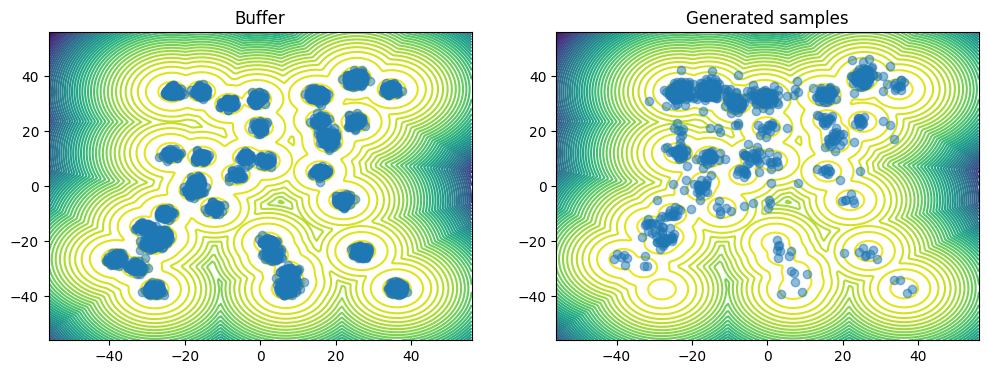

  1%|█▌                                                                                                                                                             | 10/1000 [00:19<31:49,  1.93s/it]

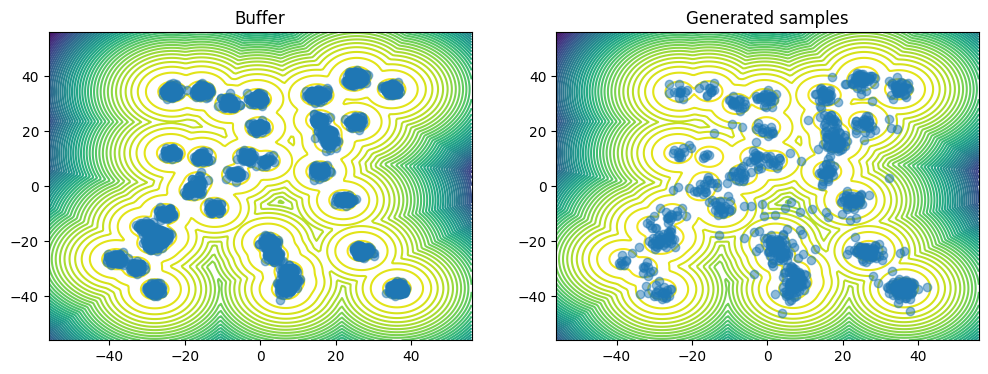

  2%|███▏                                                                                                                                                           | 20/1000 [00:39<31:36,  1.94s/it]

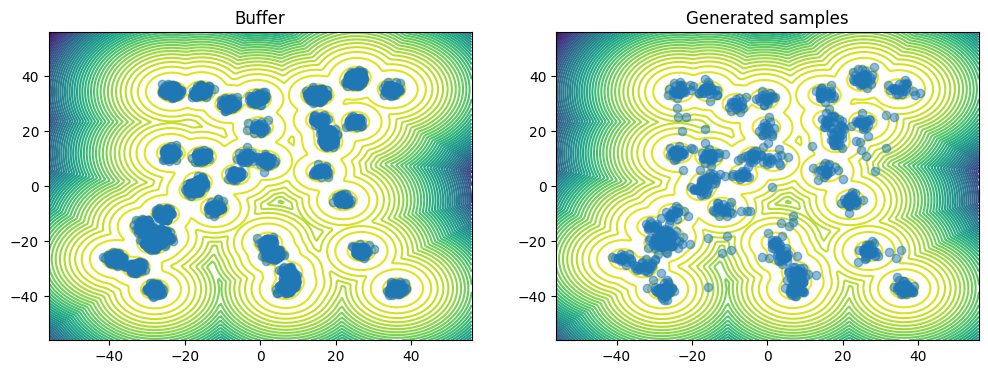

  3%|████▊                                                                                                                                                          | 30/1000 [00:59<31:15,  1.93s/it]

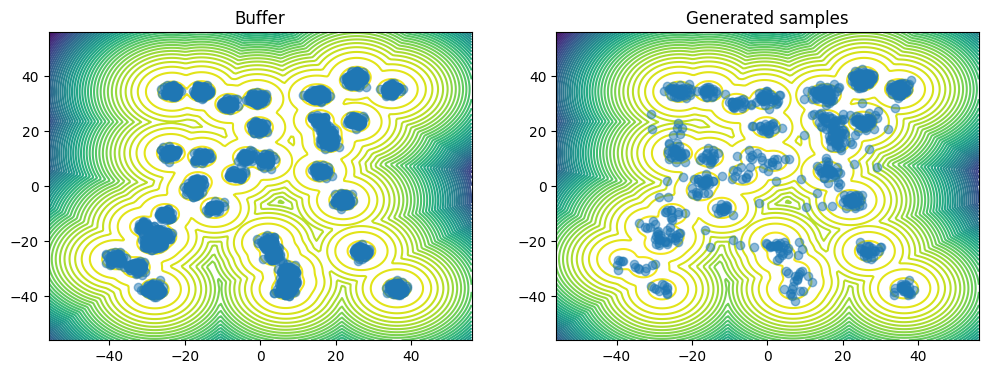

  4%|██████▎                                                                                                                                                        | 40/1000 [01:19<31:02,  1.94s/it]

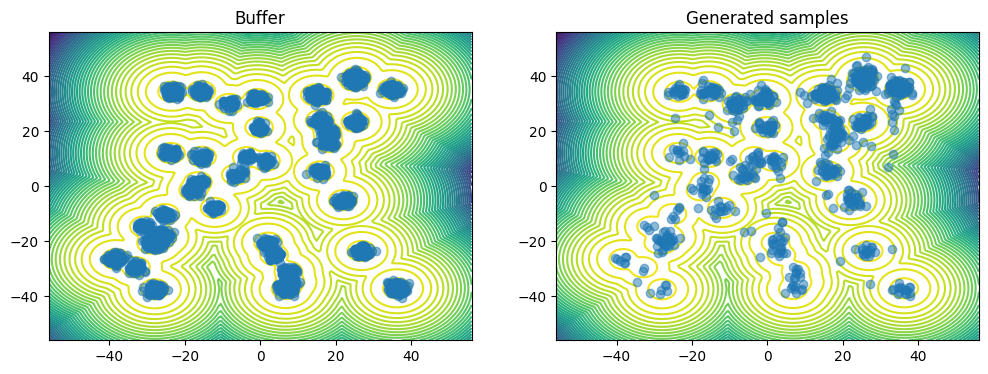

  5%|███████▉                                                                                                                                                       | 50/1000 [01:39<30:46,  1.94s/it]

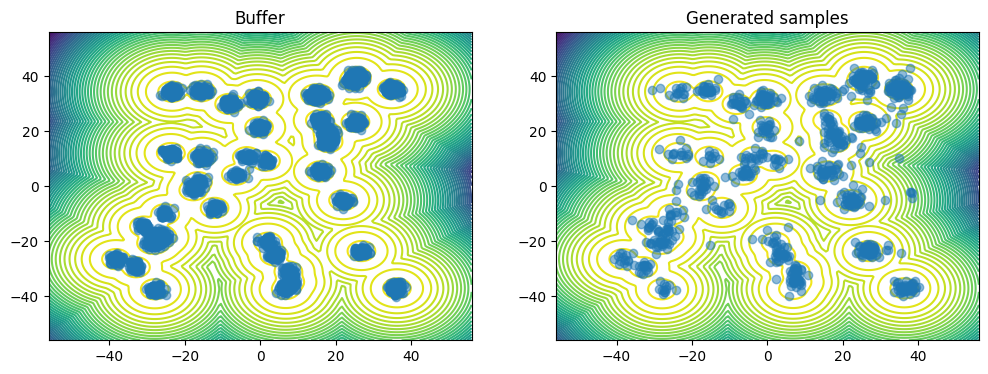

  6%|█████████▌                                                                                                                                                     | 60/1000 [02:00<31:01,  1.98s/it]

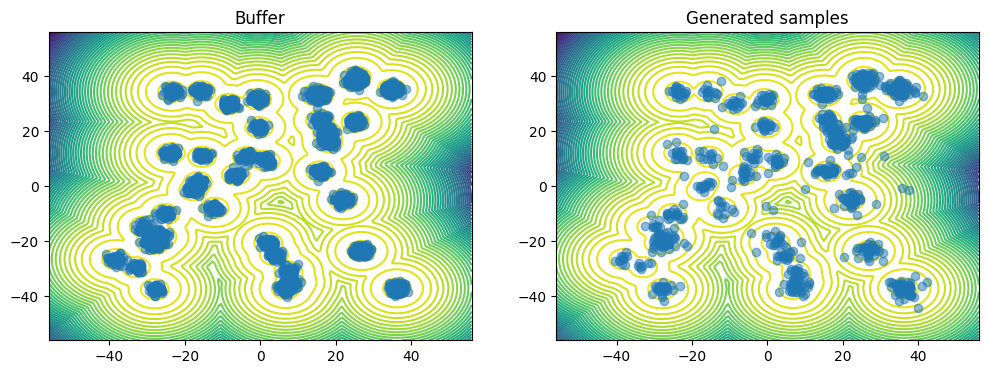

  7%|██████████▊                                                                                                                                                    | 68/1000 [02:16<31:15,  2.01s/it]


KeyboardInterrupt: 

In [20]:
all_losses = []
for outer_epoch in tqdm(range(outer_epochs)):
    # Sample data from the buffer
    samples, samples_energy, _ = buffer.sample(512 * 10)
    train_dataset = TensorDataset(samples, samples_energy)
    trainloader = DataLoader(train_dataset, batch_size = 512, shuffle=True)
    
    for epoch in range(inner_epochs):
        total_loss = 0.
        for samples,_ in trainloader:
            samples = samples.to(device)
            
            t = torch.rand(len(samples), device=device)
            noisy_x = samples + (torch.randn_like(samples) * noise_schedule.h(t).sqrt().unsqueeze(-1))
            target_score = target_score_getter.get_score(noisy_x, t)
            model_score = vectorfield(noisy_x, t)
            
            loss = torch.linalg.vector_norm(model_score - target_score, dim=-1).pow(2).mean()
                
            loss.backward()
            opt_vectorfield.step()
            opt_vectorfield.zero_grad()

            all_losses.append(loss.detach().cpu().item())
                
        if epoch % 50 == 0:
            #print("Epoch %d | Loss %f" % (epoch, loss.item()))
            pass


    # Generate samples using the network
    ve_reverse_sde = VEReverseSDE(vectorfield, noise_schedule)

    noise = torch.randn((samples_per_epoch, 2), device=device) * (noise_schedule.h(1) ** 0.5)
    samples = integrate_sde(ve_reverse_sde, noise, [0, 0.999], 1e-3)[0][-1]
    samples_energy = target.log_prob(samples).detach()
    
    # Update Buffer 
    buffer.add(samples, samples_energy)

    if outer_epoch % 10 == 0:
        plot_dataset(train_dataset.tensors[0], samples)
        plt.show()

## Computing the NLL

In [24]:
from torch.func import jacrev


def drift(x, t):
    h_t = noise_schedule.h(t)
    g_t = noise_schedule.g(t)
    f = -0.5 * g_t.unsqueeze(-1) * vectorfield(x, t)

    norm = torch.linalg.vector_norm(f, dim=-1)
    max_norm = 50
    clip_coef = torch.clamp(max_norm / (norm + 1e-6), max=1)

    return f * clip_coef.unsqueeze(-1)


def div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = torch.func.jacrev(u)

    def div(x):
        return torch.trace(J(x.unsqueeze(0)).squeeze())

    return div


def output_and_div(vecfield, x):
    dx = vecfield(x)
    div = torch.vmap(div_fn(vecfield), randomness="different")(x)

    return dx, div


def prior_dist(beta):
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(2).to(device), torch.eye(2).to(device) * beta
    )
    return dist


def odefunc(t, x_in):
    x = x_in[..., :-1].clone().detach().requires_grad_(True)
    t = t.to(device)

    def vecfield(x):
        return drift(x, torch.ones(x.shape[0]).to(device) * t)

    dx, div = output_and_div(vecfield, x)
    div = div.reshape(-1, 1)
    return torch.cat([dx, div], dim=-1)


with torch.no_grad():
    x1 = target.sample((2048,))
    t = torch.linspace(1, 0, 1000).to(device)

    state1 = torch.cat([x1, torch.zeros_like(x1[..., :1])], dim=-1)
    state1.requires_grad = True
    states_traj = odeint(odefunc, state1, t=t, method="euler")
    state0 = states_traj[-1]

    x0, logdetjac = state0[..., :-1], state0[..., -1]
    p0 = prior_dist(noise_schedule.h(1))
    logp0 = p0.log_prob(x0)
    logp1 = -(logp0 + logdetjac)

In [25]:
print("logp0", logp0.mean())
print("logdetjac", logdetjac.mean())
print("logp1", logp1.mean())

logp0 tensor(-9.5473, device='cuda:0')
logdetjac tensor(-0.5339, device='cuda:0')
logp1 tensor(10.0812, device='cuda:0')
